In [1]:
from brian2 import *
import pandas as pd

start_scope()
defaultclock.dt =  1*ms


/Users/ewa/Desktop/magisterka/MEAanalysis/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/ewa/Desktop/magisterka/MEAanalysis/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [2]:
path = "../data/spike_matrix.csv"
df = pd.read_csv(path, header=0)

tcol = df.iloc[:, 0].to_numpy(dtype=np.float32)
X = df.iloc[:, 1:].to_numpy(dtype=bool)
del df

T, N = X.shape
print(f"T (time bins): {T}, N (neurons): {N}")

T (time bins): 1800001, N (neurons): 50


In [3]:
simulation_duration = T * defaultclock.dt

Cm   = 1*pF     # pojemność błony
gL   = 10*nS      # przewodność wycieku
EL   = -70*mV     # potencjał spoczynkowy
VT   = -50*mV     # próg
Vr   = -65*mV     # reset
tau_ref = 5*ms    # okres refrakcji
Iext = 200*pA     # prąd zewnętrzny

# STDP
taupre = 20*ms
taupost = 20*ms
dApre = 0.01
dApost = -dApre*1.05


In [4]:
#SpikeGeneratorGroup
bin_idx, neuron_idx = np.nonzero(X)  # Wszystkie spiki
spike_times = (bin_idx.astype(np.int64)) * ms
spike_indices = neuron_idx.astype(np.int32)
G = SpikeGeneratorGroup(N, indices=spike_indices, times=spike_times)

In [5]:
#neurony
eqs = '''
dv/dt = (-gL*(v-EL) + Iext) / Cm : volt (unless refractory)
'''

neurons = NeuronGroup(N, eqs, threshold='v>VT', reset='v=Vr',
                refractory=tau_ref, method='euler')
# inicjujemy zmienne 
neurons.v = EL

#monitorowanie
neurons_monitor = SpikeMonitor(neurons)

In [6]:
# synapse = Synapses(G, neurons,
#                    model='''s: volt''',
#                    on_pre='v_m += s')
# synapse.connect(j='i')
# synapse.s = 100. * mV

In [7]:
S = Synapses(G, neurons, 
             '''
             w : 1
             apre : 1
             apost : 1
             ''',
             on_pre='''
             v_post += w*mV
             apre += dApre
             w = clip(w + apost, 0, 1)
             ''',
             on_post='''
             apost += dApost
             w = clip(w + apre, 0, 1)
             ''')
S.connect(j='i')  
S.w = 0.5

WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError)
Certain compiler configurations (e.g. clang in a conda environment on OS X) are known to be problematic. Note that you can switch the compiler by setting the 'CC' and 'CXX' environment variables. For example, you may want to try 'CC=gcc' and 'CXX=g++'. [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


In [8]:
run(simulation_duration)

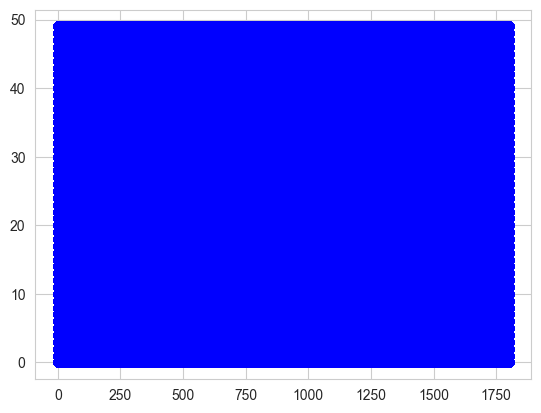

In [9]:
neurons_indices, neurons_times = neurons_monitor.it
plot(neurons_times, neurons_indices, 'ob')

In [10]:
dt_s = 0.001   
T_s = 1800             
N = 50             
T_bins = int(T_s / dt_s) 

raster = np.zeros((T_bins, N), dtype=int)

t_s = np.array(neurons_monitor.t / second)  
i_idx = np.array(neurons_monitor.i)       

for idx, t in zip(i_idx, t_s):
    tbin = int(np.floor(t / dt_s))
    if tbin < T_bins:
        raster[tbin, idx] = 1

time_s = np.arange(T_bins) * dt_s
df = pd.DataFrame(raster, columns=[f"neuron_{i}" for i in range(1, N+1)])
df.insert(0, "time_s", time_s)

In [11]:
df.to_csv("../data/spike_generated_LIF.csv", index=True)